In [1]:
# dependencies
import tensorflow as tf
import numpy as np
from sklearn.cross_validation import train_test_split
import time
import matplotlib.pyplot as plt
import pickle

In [2]:
def read_dataset(filepath):
    with open(filepath, 'rb') as fp:
        return pickle.load(fp)

In [3]:
# read dataset
dataset_location = "./data.p"
X, Y, l1_word2idx, l1_idx2word, l1_vocab, l2_word2idx, l2_idx2word, l2_vocab = read_dataset(dataset_location)

In [4]:
print(l1_vocab[:30])
print(l2_vocab[:30])

['के', '', 'में', 'है', 'की', 'और', 'से', 'को', 'का', 'हैं', 'कि', 'पर', 'एक', 'नहीं', 'लिए', 'यह', 'भी', 'इस', 'कर', 'ने', 'हो', '।', 'ही', 'करने', 'जो', 'तो', 'किया', 'या', 'था', 'आप']
['the', '', 'of', 'and', 'to', 'in', 'a', 'is', 'that', 'for', 'it', 'this', 'on', 'you', 'was', 'as', 'are', 'with', 'be', 'not', 'by', 'or', 'he', 'from', 'his', 'have', 'but', 'at', 'an', 'which']


In [5]:
# data processing

# data padding
def data_padding(x, y, length = 20):
    for i in range(len(x)):
        x[i] = x[i] + (length - len(x[i])) * [l1_word2idx['<pad>']]
        y[i] = [l2_word2idx['<go>']] + y[i] + [l2_word2idx['<eos>']] + (length-len(y[i])) * [l2_word2idx['<pad>']]

data_padding(X, Y)

# data splitting
X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

del X
del Y

In [6]:
# build a model

input_seq_len = 20
output_seq_len = 22
l1_vocab_size = len(l1_vocab) + 2 # + <pad>, <ukn>
l2_vocab_size = len(l2_vocab) + 4 # + <pad>, <ukn>, <eos>, <go>

# placeholders
encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{0}'.format(i)) for i in range(input_seq_len)]
decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{0}'.format(i)) for i in range(output_seq_len)]

targets = [decoder_inputs[i+1] for i in range(output_seq_len-1)]
# add one more target
targets.append(tf.placeholder(dtype = tf.int32, shape = [None], name = 'last_target'))
target_weights = [tf.placeholder(dtype = tf.float32, shape = [None], name = 'target_w{0}'.format(i)) for i in range(output_seq_len)]

# output projection
size = 512
w_t = tf.get_variable('proj_w', [l2_vocab_size, size], tf.float32)
b = tf.get_variable('proj_b', [l2_vocab_size], tf.float32)
w = tf.transpose(w_t)
output_projection = (w, b)

outputs, states = tf.nn.seq2seq.embedding_attention_seq2seq(
                                            encoder_inputs,
                                            decoder_inputs,
                                            tf.nn.rnn_cell.BasicLSTMCell(size),
                                            num_encoder_symbols = l1_vocab_size,
                                            num_decoder_symbols = l2_vocab_size,
                                            embedding_size = 80,
                                            feed_previous = False,
                                            output_projection = output_projection,
                                            dtype = tf.float32)

In [7]:
# define our loss function

# sampled softmax loss - returns: A batch_size 1-D tensor of per-example sampled softmax losses
def sampled_loss(logits, labels):
    return tf.nn.sampled_softmax_loss(
                        weights = w_t,
                        biases = b,
                        labels = tf.reshape(labels, [-1, 1]),
                        inputs = logits,
                        num_sampled = 512,
                        num_classes = l2_vocab_size)

# Weighted cross-entropy loss for a sequence of logits
loss = tf.nn.seq2seq.sequence_loss(outputs, targets, target_weights, softmax_loss_function = sampled_loss)

In [8]:
# simple softmax function
def softmax(x):
    n = np.max(x)
    e_x = np.exp(x - n)
    return e_x / e_x.sum()

# feed data into placeholders
def feed_dict(x, y, batch_size = 64):
    feed = {}
    
    idxes = np.random.choice(len(x), size = batch_size, replace = False)
    
    for i in range(input_seq_len):
        feed[encoder_inputs[i].name] = np.array([x[j][i] for j in idxes])
        
    for i in range(output_seq_len):
        feed[decoder_inputs[i].name] = np.array([y[j][i] for j in idxes])
        
    feed[targets[len(targets)-1].name] = np.full(shape = [batch_size], fill_value = l2_word2idx['<pad>'])
    
    for i in range(output_seq_len-1):
        batch_weights = np.ones(batch_size, dtype = np.float32)
        target = feed[decoder_inputs[i+1].name]
        for j in range(batch_size):
            if target[j] == l2_word2idx['<pad>']:
                batch_weights[j] = 0.0
        feed[target_weights[i].name] = batch_weights
        
    feed[target_weights[output_seq_len-1].name] = np.zeros(batch_size, dtype = np.float32)
    
    return feed

# decode output sequence
def decode_output(output_seq):
    words = []
    for i in range(output_seq_len):
        smax = softmax(output_seq[i])
        idx = np.argmax(smax)
        words.append(l2_idx2word[idx])
    return words

In [9]:
# ops and hyperparameters
learning_rate = 3e-3
batch_size = 8
steps = 40000

# ops for projecting outputs
outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

# training op
optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=0.99).minimize(loss)

# init op
init = tf.global_variables_initializer()

# forward step
def forward_step(sess, feed):
    output_sequences = sess.run(outputs_proj, feed_dict = feed)
    return output_sequences

# training step
def backward_step(sess, feed):
    sess.run(optimizer, feed_dict = feed)

In [10]:
# we will use this list to plot losses through steps
losses = []

# save a checkpoint so we can restore the model later 
saver = tf.train.Saver()

print('------------------TRAINING------------------')

with tf.Session() as sess:
    sess.run(init)
    
    t = time.time()
    for step in range(steps):
        feed = feed_dict(X_train, Y_train)
            
        backward_step(sess, feed)
        
        if step % 50 == 49 or step == 0:
            loss_value = sess.run(loss, feed_dict = feed)
            print('step: {}, loss: {}'.format(step, loss_value))
            losses.append(loss_value)
        
        if step % 1000 == 999:
            saver.save(sess, './checkpoints/', global_step=step)
            print('Checkpoint is saved')
            
    print('Training time for {} steps: {}s'.format(steps, time.time() - t))

------------------TRAINING------------------
step: 0, loss: 9.30533218383789
step: 49, loss: 6.387561798095703
step: 99, loss: 6.536971092224121
step: 149, loss: 5.150188446044922
step: 199, loss: 4.962061882019043
step: 249, loss: 5.49918270111084
step: 299, loss: 5.422075271606445
step: 349, loss: 5.663182258605957
step: 399, loss: 4.708776950836182
step: 449, loss: 4.79289436340332
step: 499, loss: 4.60256814956665
step: 549, loss: 4.5296502113342285
step: 599, loss: 4.785130500793457
step: 649, loss: 4.505695819854736
step: 699, loss: 4.381748199462891
step: 749, loss: 4.189996719360352
step: 799, loss: 4.391980171203613
step: 849, loss: 3.696199893951416
step: 899, loss: 3.9169869422912598
step: 949, loss: 3.935019016265869
step: 999, loss: 3.7516911029815674
Checkpoint is saved
step: 1049, loss: 3.5869140625
step: 1099, loss: 3.64778470993042
step: 1149, loss: 3.3666839599609375
step: 1199, loss: 3.590575695037842
step: 1249, loss: 3.3249871730804443
step: 1299, loss: 3.396311283

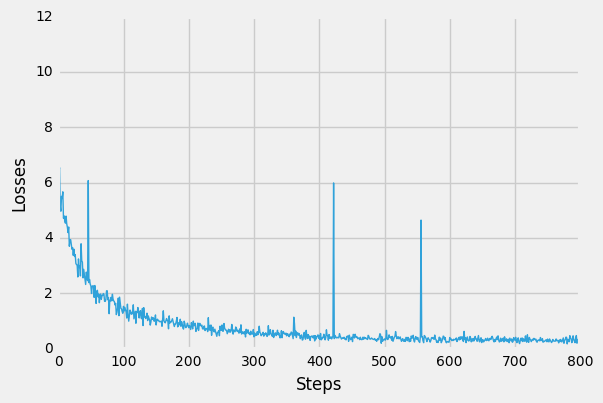

In [11]:
# plot losses

with plt.style.context('fivethirtyeight'):
    plt.plot(losses, linewidth = 1)
    plt.xlabel('Steps')
    plt.ylabel('Losses')
    plt.ylim((0, 12))

plt.show()

In [15]:
encoded_test = {'X':X_test, 'Y':Y_test}
pickle.dump(encoded_test, open("./encoded_test.p", mode='wb'))